[View in Colaboratory](https://colab.research.google.com/github/pmanlukas/colabSVM/blob/master/openapi_classifier.ipynb)

# openAPI spec classifier
This notebook is used to create a first proof of concept on a classifier for openAPI files. The classifier will be based on a neural network based architecture and will be implemented in Tensorflow, SciPy and Keras.

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Create a folder to use for the project data
!mkdir -p /content/drive/openapi-data/

In [6]:
!ls /content/drive/openapi-data/

CNN_cat.h5	       LSTMCNN_cat_weights.h5	PoC Classifier Path.odt
CNN_cat_weights.h5     mnist.py			structure_labels0518.csv
CNN_struct.h5	       new_path_labels0518.csv	structure_labels.csv
CNN_struct_weights.h5  path_labels0518.csv	weights.best.hdf5
glove.6B.zip	       path_labels.csv		wordvector
LSTMCNN_cat.h5	       pickle


In [7]:
!pip install -q keras
!pip install -q graphviz
import keras
import graphviz

Using TensorFlow backend.


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
os.chdir("drive/openapi-data")

In [10]:
!ls

CNN_cat.h5	       LSTMCNN_cat_weights.h5	PoC Classifier Path.odt
CNN_cat_weights.h5     mnist.py			structure_labels0518.csv
CNN_struct.h5	       new_path_labels0518.csv	structure_labels.csv
CNN_struct_weights.h5  path_labels0518.csv	weights.best.hdf5
glove.6B.zip	       path_labels.csv		wordvector
LSTMCNN_cat.h5	       pickle


## Import Data Sets

In [0]:
import pickle

In [0]:
training_data = dict()

with open('pickle/specjson210518.pkl', 'rb') as handle:
    training_data = pickle.load(handle)

In [0]:
training_info = dict()

with open('pickle/infodict0518.pkl', 'rb') as handle:
    training_info = pickle.load(handle)

In [0]:
cat_data = dict()

with open('pickle/spec_category0518.pkl', 'rb') as handle:
    cat_data = pickle.load(handle)

In [15]:
cat_info = dict()
for cat in cat_data:
    info = cat_data[cat]['info']
    cat_info[cat] = info
print(cat_info.keys())

dict_keys(['1forge.com', '6-dot-authentiqio.appspot.com', 'adafruit.com', 'adobe.com:aem', 'adyen.com:CheckoutService', 'adyen.com:PaymentService', 'adyen.com:RecurringService', 'afterbanks.com', 'agco-ats.com', 'airport-web.appspot.com', 'amazonaws.com:AWSMigrationHub', 'amazonaws.com:acm', 'amazonaws.com:acm-pca', 'amazonaws.com:alexaforbusiness', 'amazonaws.com:apigateway', 'amazonaws.com:application-autoscaling', 'amazonaws.com:appstream', 'amazonaws.com:appsync', 'amazonaws.com:athena', 'amazonaws.com:autoscaling', 'amazonaws.com:autoscaling-plans', 'amazonaws.com:batch', 'amazonaws.com:budgets', 'amazonaws.com:ce', 'amazonaws.com:cloud9', 'amazonaws.com:clouddirectory', 'amazonaws.com:cloudformation', 'amazonaws.com:cloudfront', 'amazonaws.com:cloudhsm', 'amazonaws.com:cloudhsmv2', 'amazonaws.com:cloudsearch', 'amazonaws.com:cloudsearchdomain', 'amazonaws.com:cloudtrail', 'amazonaws.com:codebuild', 'amazonaws.com:codecommit', 'amazonaws.com:codedeploy', 'amazonaws.com:codepipelin

In [16]:
paths = dict()
for path in training_data:
    info = training_data[path]['paths']
    paths[path] = info
print(paths.keys())

dict_keys(['1forge.com', '6-dot-authentiqio.appspot.com', 'adafruit.com', 'adobe.com:aem', 'adyen.com:CheckoutService', 'adyen.com:PaymentService', 'adyen.com:RecurringService', 'afterbanks.com', 'agco-ats.com', 'airport-web.appspot.com', 'amadeus.com', 'amazonaws.com:AWSMigrationHub', 'amazonaws.com:acm', 'amazonaws.com:acm-pca', 'amazonaws.com:alexaforbusiness', 'amazonaws.com:apigateway', 'amazonaws.com:application-autoscaling', 'amazonaws.com:appstream', 'amazonaws.com:appsync', 'amazonaws.com:athena', 'amazonaws.com:autoscaling', 'amazonaws.com:autoscaling-plans', 'amazonaws.com:batch', 'amazonaws.com:budgets', 'amazonaws.com:ce', 'amazonaws.com:cloud9', 'amazonaws.com:clouddirectory', 'amazonaws.com:cloudformation', 'amazonaws.com:cloudfront', 'amazonaws.com:cloudhsm', 'amazonaws.com:cloudhsmv2', 'amazonaws.com:cloudsearch', 'amazonaws.com:cloudsearchdomain', 'amazonaws.com:cloudtrail', 'amazonaws.com:codebuild', 'amazonaws.com:codecommit', 'amazonaws.com:codedeploy', 'amazonaws.

In [0]:
cat_label = dict()

with open('pickle/categories_dict0518.pkl', 'rb') as handle:
    cat_label = pickle.load(handle)

In [20]:
cat_label[keys[0]]

'financial'

In [0]:
keys = list(training_data.keys())

In [21]:
training_data[keys[0]]

{'basePath': '/forex-quotes',
 'host': '1forge.com',
 'info': {'contact': {'email': 'contact@1forge.com',
   'name': '1Forge',
   'url': 'http://1forge.com'},
  'description': 'Stock and Forex Data and Realtime Quotes',
  'title': '1Forge Finance APIs',
  'version': '0.0.1',
  'x-apisguru-categories': ['financial'],
  'x-logo': {'backgroundColor': '#24292e',
   'url': 'https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png'},
  'x-origin': [{'format': 'swagger',
    'url': 'http://1forge.com/openapi.json',
    'version': '2.0'}],
  'x-preferred': True,
  'x-providerName': '1forge.com'},
 'paths': {'/quotes': {'get': {'description': 'Get quotes',
    'externalDocs': {'description': 'Find out more',
     'url': 'http://1forge.com/forex-data-api'},
    'responses': {'200': {'description': 'A list of quotes'}},
    'summary': 'Get quotes for all symbols',
    'tags': ['forex', 'finance', 'quotes']}},
  '/symbols': {'get': {'description': 'Symbol List',
    'externalDocs': {'descripti

In [0]:
from collections import Counter
from datetime import datetime
 
import json
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np
import pandas as pd

In [23]:
!ls

CNN_cat.h5	       LSTMCNN_cat_weights.h5	PoC Classifier Path.odt
CNN_cat_weights.h5     mnist.py			structure_labels0518.csv
CNN_struct.h5	       new_path_labels0518.csv	structure_labels.csv
CNN_struct_weights.h5  path_labels0518.csv	weights.best.hdf5
glove.6B.zip	       path_labels.csv		wordvector
LSTMCNN_cat.h5	       pickle


### prepare labels and text

In [0]:
labelsP = pd.read_csv("new_path_labels0518.csv").values
labelsS  = pd.read_csv("structure_labels0518.csv").values

In [130]:
labelsPath = list()
labelsStruct = list()
labelsCat = list()

for labs in labelsS:
  labelsStruct.append(labs[1])

for labp in labelsP:
  labelsPath.append(labp[1])
  
for labc in cat_label:
  labelsCat.append(cat_label[labc])
  
print(str(len(labelsPath)))
print(str(len(labelsStruct)))
print(str(len(labelsCat)))

1034
1034
944


In [131]:
labelsCat

['financial',
 'security',
 'iot',
 'marketing',
 'payment',
 'payment',
 'payment',
 'financial',
 'ecommerce',
 'transport',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'cloud',
 'c

In [132]:
texts = []   # list of text samples
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  texts.append(strJson)

print(str(len(texts)))

1034


In [133]:
texts_paths = []   # list of text samples
for path_obj in paths:
  strJson = json.dumps(paths[path_obj])
  texts_paths.append(strJson)

print(str(len(texts_paths)))

1034


In [134]:
print(len(min(texts_paths, key=len)))

309


In [135]:
#turn info objects into strings

texts_info= []   # list of text samples
for info in training_info:
  strJson = json.dumps(training_info[info])
  texts_info.append(strJson)

print(str(len(texts_info)))

1034


In [136]:

texts_cat = []   # list of text samples
for cat in cat_data:
  strJson = json.dumps(cat_data[cat])
  texts_cat.append(strJson)

print(str(len(texts_cat)))

944


In [137]:
#turn info objects into strings

texts_info_cat = []   # list of text samples
for cat in cat_info:
  strJson = json.dumps(cat_info[cat])
  texts_info_cat.append(strJson)

print(str(len(texts_info_cat)))

944


## test word embeddings

In [138]:
print(type(texts[0]))
print(texts[0])

<class 'str'>
{"swagger": "2.0", "schemes": ["https", "http"], "host": "1forge.com", "basePath": "/forex-quotes", "info": {"contact": {"email": "contact@1forge.com", "name": "1Forge", "url": "http://1forge.com"}, "description": "Stock and Forex Data and Realtime Quotes", "title": "1Forge Finance APIs", "version": "0.0.1", "x-apisguru-categories": ["financial"], "x-logo": {"backgroundColor": "#24292e", "url": "https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png"}, "x-origin": [{"format": "swagger", "url": "http://1forge.com/openapi.json", "version": "2.0"}], "x-preferred": true, "x-providerName": "1forge.com"}, "produces": ["application/json"], "paths": {"/quotes": {"get": {"description": "Get quotes", "externalDocs": {"description": "Find out more", "url": "http://1forge.com/forex-data-api"}, "responses": {"200": {"description": "A list of quotes"}}, "summary": "Get quotes for all symbols", "tags": ["forex", "finance", "quotes"]}}, "/symbols": {"get": {"description": "Symbol L

In [0]:
from sklearn import model_selection, preprocessing, linear_model

#encoder for labels of category
encoder = preprocessing.LabelEncoder()
labelsCat = encoder.fit_transform(labelsCat)


In [140]:
labelsC = labelsCat  # list of label ids
print(type(labelsC))
print(labelsC)

<class 'numpy.ndarray'>
[11 23 13 16 21 21 21 11  6 31  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  5 18 29  6  6  5 20 28 28 28 28 28 28  5 28 28 28 28 28
 28 28 28 28 28 28 28 28 28  5 22 22 17 11 20 23  3 31  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2

In [141]:


labels = labelsStruct  # list of label ids
print(type(labels))
print(labels)

<class 'list'>
[1, 2, 3, 3, 1, 1, 1, 1, 1, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 4, 2, 1, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 1, 1, 3, 4, 2, 5, 3, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 3, 3, 3, 6, 3, 3, 6, 7, 7, 7, 7, 7, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 

In [142]:
labelsP = labelsPath  # list of label ids
print(type(labelsP))
print(labelsP)

<class 'list'>
[1, 2, 3, 3, 1, 2, 1, 1, 3, 1, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 1, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 1, 1, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 3, 2, 2, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1, 2, 3, 3, 2, 3, 3, 3, 

In [143]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labels)
y_train = encoder.transform(labels)

y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [144]:
encoder = LabelBinarizer()
encoder.fit(labelsP)
yp_train = encoder.transform(labelsP)

yp_train

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [145]:
encoder = LabelBinarizer()
encoder.fit(labelsC)
yc_train = encoder.transform(labelsC)

yc_train[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

In [0]:
MAX_SEQUENCE_LENGTH = 75000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [148]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = y_train #keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 151535 unique tokens.
Shape of data tensor: (1034, 75000)
Shape of label tensor: (1034, 8)


In [149]:
embeddings_index = {}
f = open(os.path.join('wordvector', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py

In [153]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(256, 5, kernel_regularizer=regularizers.l2(0.01), padding="valid", kernel_initializer='normal', activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
#x = BatchNormalization()(x)

x = Conv1D(256, 5, kernel_regularizer=regularizers.l2(0.01), padding="valid", kernel_initializer='normal', activation='relu')(x)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
#x = BatchNormalization()(x)

x = Conv1D(256, 5, kernel_regularizer=regularizers.l2(0.01), padding="valid", kernel_initializer='normal', activation='relu')(x)
x = GlobalMaxPooling1D()(x)  # global max pooling
#x = Dropout(0.2)(x)
#x = BatchNormalization()(x)

x = Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
#x = Dropout(0.2)(x)
#x = BatchNormalization()(x)

preds = Dense(8, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['acc'])
summary = model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 75000)             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 75000, 100)        2000000   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 74996, 256)        128256    
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 14999, 256)        0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 14995, 256)        327936    
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 2999, 256)         0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 2995, 256)         327936    
__________

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [155]:
# happy learning!
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2, callbacks=callbacks_list)

Train on 662 samples, validate on 166 samples
Epoch 1/15
662/662 [==============================] - 54s 82ms/step - loss: 25.3229 - acc: 0.1994 - val_loss: 21.2977 - val_acc: 0.3253

Epoch 00001: val_acc improved from -inf to 0.32530, saving model to weights.best.hdf5
Epoch 2/15
662/662 [==============================] - 46s 69ms/step - loss: 18.8775 - acc: 0.3580 - val_loss: 16.7009 - val_acc: 0.5422

Epoch 00002: val_acc improved from 0.32530 to 0.54217, saving model to weights.best.hdf5
Epoch 3/15
662/662 [==============================] - 46s 69ms/step - loss: 15.0557 - acc: 0.6314 - val_loss: 13.5122 - val_acc: 0.6687

Epoch 00003: val_acc improved from 0.54217 to 0.66867, saving model to weights.best.hdf5
Epoch 4/15
662/662 [==============================] - 46s 69ms/step - loss: 12.2729 - acc: 0.7100 - val_loss: 11.2247 - val_acc: 0.7229

Epoch 00004: val_acc improved from 0.66867 to 0.72289, saving model to weights.best.hdf5
Epoch 5/15
662/662 [==============================] -

662/662 [==============================] - 46s 69ms/step - loss: 7.3947 - acc: 0.8157 - val_loss: 7.0352 - val_acc: 0.7349

Epoch 00007: val_acc improved from 0.72289 to 0.73494, saving model to weights.best.hdf5
Epoch 8/15
662/662 [==============================] - 46s 69ms/step - loss: 6.3327 - acc: 0.8701 - val_loss: 6.1681 - val_acc: 0.7530

Epoch 00008: val_acc improved from 0.73494 to 0.75301, saving model to weights.best.hdf5
Epoch 9/15
662/662 [==============================] - 46s 69ms/step - loss: 5.4585 - acc: 0.9033 - val_loss: 5.3426 - val_acc: 0.7831

Epoch 00009: val_acc improved from 0.75301 to 0.78313, saving model to weights.best.hdf5
Epoch 10/15
662/662 [==============================] - 46s 69ms/step - loss: 4.7689 - acc: 0.9245 - val_loss: 4.7455 - val_acc: 0.7711

Epoch 00010: val_acc did not improve from 0.78313
Epoch 11/15
662/662 [==============================] - 46s 69ms/step - loss: 4.1761 - acc: 0.9637 - val_loss: 4.2396 - val_acc: 0.7831

Epoch 00011: val_

662/662 [==============================] - 46s 69ms/step - loss: 3.2672 - acc: 0.9728 - val_loss: 3.6165 - val_acc: 0.7470

Epoch 00013: val_acc did not improve from 0.78313
Epoch 14/15
662/662 [==============================] - 46s 69ms/step - loss: 3.0188 - acc: 0.9124 - val_loss: 3.2267 - val_acc: 0.7651

Epoch 00014: val_acc did not improve from 0.78313
Epoch 15/15
662/662 [==============================] - 45s 69ms/step - loss: 2.6947 - acc: 0.9486 - val_loss: 3.0035 - val_acc: 0.7771

Epoch 00015: val_acc did not improve from 0.78313


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


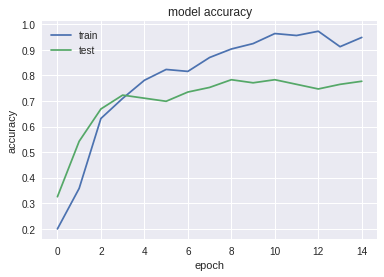

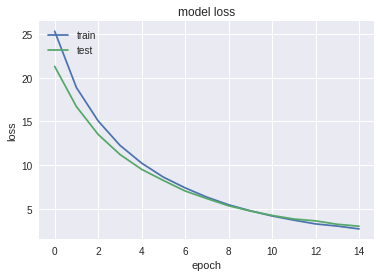

In [156]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [158]:
score = model.evaluate(x_val, y_val,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

206/206 [==============================] - 7s 34ms/step
Test score: 4.294131797494241
Test accuracy: 0.75728155455543


In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [0]:
y_softmax = model.predict(x_val)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_val)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [161]:
print(y_test_1d)
print(y_pred_1d)

[5, 2, 2, 5, 7, 4, 3, 4, 0, 5, 5, 4, 4, 7, 5, 7, 4, 3, 0, 2, 2, 0, 4, 5, 3, 7, 5, 6, 2, 5, 7, 6, 2, 6, 6, 3, 5, 6, 6, 7, 7, 1, 1, 3, 6, 6, 6, 3, 3, 4, 7, 7, 4, 1, 6, 7, 3, 3, 7, 4, 6, 2, 4, 3, 4, 7, 2, 2, 4, 0, 2, 3, 1, 6, 5, 6, 4, 4, 3, 6, 5, 4, 6, 2, 2, 4, 6, 3, 5, 4, 0, 6, 6, 7, 1, 6, 2, 0, 2, 6, 2, 2, 6, 7, 2, 2, 4, 4, 0, 7, 7, 5, 6, 1, 6, 3, 1, 2, 5, 0, 0, 6, 3, 7, 6, 3, 6, 6, 2, 6, 6, 2, 0, 4, 7, 0, 5, 6, 2, 6, 6, 6, 6, 7, 1, 7, 4, 5, 0, 6, 4, 5, 3, 6, 7, 5, 0, 7, 6, 2, 4, 4, 2, 4, 4, 0, 4, 6, 6, 7, 7, 4, 4, 6, 2, 6, 6, 2, 6, 4, 2, 6, 6, 4, 7, 2, 7, 1, 6, 6, 6, 3, 0, 4, 4, 2, 0, 3, 5, 7, 2, 3, 7, 3, 2, 0]
[5, 2, 1, 5, 7, 4, 0, 4, 0, 5, 5, 2, 4, 7, 5, 7, 4, 3, 0, 2, 2, 0, 4, 5, 0, 7, 5, 6, 2, 5, 7, 6, 2, 6, 6, 0, 6, 6, 6, 7, 7, 1, 3, 3, 6, 6, 6, 0, 0, 4, 3, 7, 1, 1, 6, 7, 3, 0, 7, 2, 6, 2, 4, 0, 4, 0, 2, 0, 4, 0, 2, 2, 1, 6, 5, 6, 4, 4, 2, 6, 5, 1, 6, 5, 4, 4, 6, 3, 5, 2, 0, 6, 6, 7, 0, 6, 6, 0, 0, 6, 0, 1, 6, 7, 2, 2, 4, 4, 2, 7, 3, 5, 6, 4, 6, 0, 1, 2, 2, 0, 0, 6, 3, 7, 6, 0, 6,

In [0]:
from keras.models import load_model

model.save('CNN_struct.h5')  # creates a HDF5 file 'my_model.h5'
model.save_weights('CNN_struct_weights.h5')

## different CNN Architecture

https://chrisalbon.com/deep_learning/keras/k-fold_cross-validating_neural_networks/

In [0]:
# Create function returning a compiled network
def create_network():
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sequence_input)

  x = Conv1D(256, 5, kernel_regularizer=regularizers.l2(0.01), padding="valid", kernel_initializer='normal', activation='relu')(embedded_sequences)
  x = MaxPooling1D(5)(x)
  #x = Dropout(0.2)(x)
  #x = BatchNormalization()(x)

  x = Conv1D(256, 5, kernel_regularizer=regularizers.l2(0.01), padding="valid", kernel_initializer='normal', activation='relu')(x)
  x = MaxPooling1D(5)(x)
  #x = Dropout(0.2)(x)
  #x = BatchNormalization()(x)

  x = Conv1D(256, 5, kernel_regularizer=regularizers.l2(0.01), padding="valid", kernel_initializer='normal', activation='relu')(x)
  x = GlobalMaxPooling1D()(x)  # global max pooling
  #x = Dropout(0.2)(x)
  #x = BatchNormalization()(x)

  x = Dense(256, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
  #x = Dropout(0.2)(x)
  #x = BatchNormalization()(x)

  preds = Dense(3, activation='softmax')(x)

  model = Model(sequence_input, preds)
  model.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics=['acc'])

  return model

In [0]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=10, 
                                 batch_size=32, 
                                 verbose=0)

In [66]:
# Evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, x_train, y_train, cv=10)

array([0.5515873 , 0.58333334, 0.57142857])

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [0]:
y_pred = cross_val_predict(neural_network,x_val,y_val,cv=10)



In [71]:
y_pred

array([31, 31, 31, 20,  2,  2, 31,  2,  2, 20, 31, 31,  2,  2,  2, 31, 31,
        2, 20,  5,  2, 10, 17,  5,  5, 17,  5,  5, 31,  2, 28,  5,  2, 10,
        2,  5,  2,  2,  9,  2,  2, 10, 11,  2, 10, 10,  2,  9,  2,  9,  2,
        2,  9,  9,  2,  9, 10, 31, 10, 10, 31, 10, 10,  2,  2, 10,  2,  2,
        2,  2, 10,  2, 28,  2,  2, 10,  5, 10,  2, 10, 10,  2, 15, 15,  2,
        2, 24,  2, 27, 10,  2, 24, 24, 10, 15, 31, 10, 17,  2,  2,  2,  2,
       27, 10,  2,  2,  2, 31,  2,  2,  2,  2, 10, 10,  2, 10,  2, 10, 10,
        2,  2,  9, 26,  9, 28,  9, 10,  2,  2, 14,  9, 10,  9, 10, 28,  2,
        2,  2, 28, 21,  2, 10, 28,  2,  2,  2,  2, 28,  2, 28,  2,  2, 28,
       24,  2,  2,  2, 24,  2, 28, 28, 24,  2,  2,  2,  2,  2, 28, 28,  2,
       22,  8,  2,  8,  2,  2,  2, 22,  8,  8,  1,  8,  2,  2,  8,  8,  8,
        8])

In [73]:
y_val

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

## Simple LSTM


In [104]:
from keras.models import Sequential
from keras.layers import *

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


model_lstm = Sequential()
model_lstm.add(Embedding(50000, 100, input_length=MAX_SEQUENCE_LENGTH))

model_lstm.add(Conv1D(128, 5, activation='relu'))
model_lstm.add(MaxPooling1D(pool_size=5))
model_lstm.add(BatchNormalization())

model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(BatchNormalization())

model_lstm.add(Dense(3, activation='softmax'))


model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50000, 100)        5000000   
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 49996, 128)        64128     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 9999, 128)         0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 9999, 128)         512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
batch_normalization_20 (Batc (None, 100)               400       
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 303       
Total para

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [106]:
history = model_lstm.fit(x_train, y_train,
                    batch_size=8,
                    epochs=4,
                    verbose=1,
                    validation_split=0.2, callbacks=callbacks_list)

Train on 662 samples, validate on 166 samples
Epoch 1/4
208/662 [========>.....................] - ETA: 33:54 - loss: 1.6108 - acc: 0.3077

KeyboardInterrupt: ignored

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


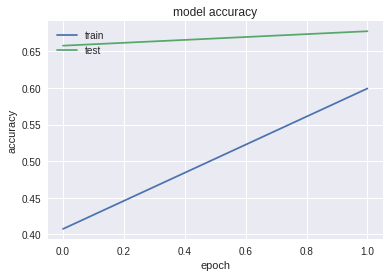

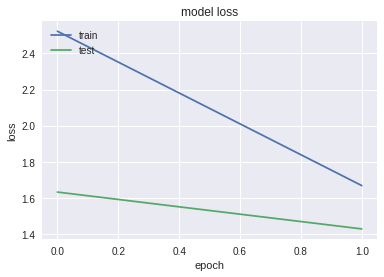

In [86]:


print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model_lstm.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [88]:
score = model_lstm.evaluate(x_val, y_val,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

188/188 [==============================] - 33s 176ms/step
Test score: 1.59543133289256
Test accuracy: 0.6329787208678874


In [0]:
model_lstm.save('LSTMCNN_cat.h5')  # creates a HDF5 file 'my_model.h5'
model_lstm.save_weights('LSTMCNN_cat_weights.h5')

### Create training and test split of the labels

In [0]:
from sklearn.model_selection import train_test_split

#split the data and labels into a test and train set
X_trainS, X_testS, y_trainS, y_testS = train_test_split(texts, labelsStruct, test_size=0.3, random_state=0)

In [0]:
#split the data and labels into a test and train set
X_trainP, X_testP, y_trainP, y_testP = train_test_split(texts, labelsPath, test_size=0.3, random_state=0)

In [0]:
#split for category texts and labels
X_trainC, X_testC, y_trainC, y_testC = train_test_split(cat_texts, labelsCat, test_size=0.3, random_state=0)

---------------------------------------------------------------

## Model Architecture
In this section of the notebook the actual deep learning model is designed and the architecture presented before the actual training of it will take place.

In [0]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=100000))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax',name = 'softmax_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [114]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100000, 128)       1280000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 100000, 128)       0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 99996, 64)         41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 24999, 64)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 24999, 64)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
__________

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=8,
                    epochs=3,
                    verbose=1,
                    validation_split=0.2)

Train on 646 samples, validate on 162 samples
Epoch 1/3
  8/646 [..............................] - ETA: 1:48:40 - loss: 2.0601 - acc: 0.3750

In [0]:
model2 = Sequential()
model2.add(Dense(2048, input_shape=(100000,), activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='sigmoid'))
model2.add(Dropout(0.2))
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [110]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2048)              204802048 
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 8200      
Total params: 206,908,424
Trainable params: 206,908,424
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history2 = model2.fit(x_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2)

### first training

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
score = model2.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)


In [0]:
loss_and_metrics = model2.evaluate(x_test, y_test, batch_size=128)


### Use Model

In [0]:
classes = model.predict(x_test, batch_size=128)


In [0]:
classes2 = model2.predict(x_test, batch_size=128)